In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image
from random import shuffle
from keras.models import Model
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.regularizers import l1
from keras.models import Sequential
from keras.applications import ResNet152V2
from keras.applications import MobileNetV2
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPool2D,Dense,Flatten, AveragePooling2D, Dropout, Input, DepthwiseConv2D, SeparableConv2D
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [3]:
Map = {'1':0, '2':1, '5':2, '10':3, '20':4, '50':5, '100':6, '200':7, '500':8, '1000':9}
notes = [1, 2, 5, 10, 20, 50, 100,200, 500, 1000]
IMG_SIZE = 128
training_data = []
validation_data = []
testing_data = []

In [5]:
def create_train_data():
    DIR = "TK4/Training/"
    for tki in range(0,10):
        DIR2 = DIR + str(notes[tki])
        
        sl = 0;
        for img in tqdm(os.listdir(DIR2)):
            label = tki
            #print(label)
            path = os.path.join(DIR2, img)
            #img = cv2.imread(path)
            #img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = Image.open(path)
            img = img.resize((IMG_SIZE, IMG_SIZE))
            training_data.append([np.array(img), label])
            sl = sl+1
           # if sl==200:
            #    break
            
  
    shuffle(training_data)

In [6]:
create_train_data()

 22%|█████████████████▋                                                              | 199/900 [00:04<00:16, 42.24it/s]


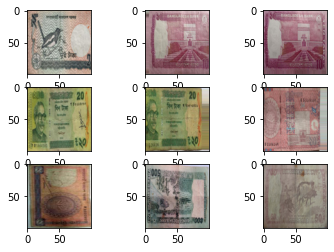

In [7]:
for i in range(9):
  plt.subplot(330+1+i)
  plt.imshow(training_data[i][0])
plt.show()

In [8]:
for i in range(9):
  print(notes[training_data[i][1]], end=' ')

2 10 10 20 20 10 1 500 50 

In [9]:
X = np.array([i[0] for i in training_data])
Y = np.array([i[1] for i in training_data])

X1, X2, Y1, Y2 = train_test_split(X, Y, test_size = 0.33, random_state=42, stratify=Y)
#X3, X4, Y3, Y4 = train_test_split(X2, Y2, test_size = 0.50, random_state=42, stratify=Y)

train_x = X1
train_y = Y1
val_x = X2
val_y = Y2
#test_x = X4
#test_y = Y4

print(Y1)

print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)
#print(test_y.shape)


train_len = train_y.shape[0]
val_len = val_y.shape[0]
#test_len = test_y.shape[0]
print(train_len)

[8 8 5 ... 5 6 2]
(1340, 100, 100, 3)
(1340,)
(660, 100, 100, 3)
(660,)
1340


In [10]:
train_x = train_x.reshape(train_len, IMG_SIZE, IMG_SIZE, 3)
val_x = val_x.reshape(val_len, IMG_SIZE, IMG_SIZE, 3)
#test_x = test_x.reshape(test_len, IMG_SIZE, IMG_SIZE, 3)

train_x = train_x.astype('float32')
val_x = val_x.astype('float32')
#test_x = test_x.astype('float32')

train_x/=255
val_x/=255
#test_x/=255

In [11]:
print(train_y)
n_classes = 10
train_y = np_utils.to_categorical(train_y, n_classes)
val_y = np_utils.to_categorical(val_y, n_classes)
#test_y = np_utils.to_categorical(test_y, n_classes)

[8 8 5 ... 5 6 2]


In [12]:
baseModel = ResNet152V2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3)))

baseModel.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 52, 52, 64)   0           conv1_conv[0][0]                 
________________________________________________________________________________________

conv4_block36_out (Add)         (None, 4, 4, 1024)   0           max_pooling2d_2[0][0]            
                                                                 conv4_block36_3_conv[0][0]       
__________________________________________________________________________________________________
conv5_block1_preact_bn (BatchNo (None, 4, 4, 1024)   4096        conv4_block36_out[0][0]          
__________________________________________________________________________________________________
conv5_block1_preact_relu (Activ (None, 4, 4, 1024)   0           conv5_block1_preact_bn[0][0]     
__________________________________________________________________________________________________
conv5_block1_1_conv (Conv2D)    (None, 4, 4, 512)    524288      conv5_block1_preact_relu[0][0]   
__________________________________________________________________________________________________
conv5_block1_1_bn (BatchNormali (None, 4, 4, 512)    2048        conv5_block1_1_conv[0][0]        
__________

In [13]:
from keras.layers import BatchNormalization
from keras.layers import Activation
headModel = baseModel.output
#headModel = AveragePooling2D(pool_size=(1, 1))(headModel)
#headModel2 = Conv2D(32, kernel_size=(2,2), strides=(1,1), padding="valid", activation="relu")(headModel2)
#headModel2 = MaxPool2D(pool_size=(2,2))(headModel2)

headModel = Flatten(name="flatten")(headModel)
headModel = Dense(1024, activation="relu", activity_regularizer=l1(0.0001))(headModel)
headModel = BatchNormalization()(headModel)
headModel = Activation("relu")(headModel)

headModel = Dropout(0.2)(headModel)

headModel = Dense(512, activation="relu")(headModel)
headModel = BatchNormalization()(headModel)
headModel = Activation("relu")(headModel)
headModel = Dense(256, activation="relu")(headModel)

headModel = Dense(n_classes, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = False

#model.summary()
print(type(model))

<class 'tensorflow.python.keras.engine.functional.Functional'>


In [14]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
his2 = model.fit(train_x, train_y, batch_size=64, epochs=10, validation_data=(val_x, val_y))

Epoch 1/10
21/21 [==============================] - 255s 11s/step - loss: 1.2533 - accuracy: 0.6984 - val_loss: 0.3514 - val_accuracy: 0.9667
Epoch 2/10
21/21 [==============================] - 206s 10s/step - loss: 0.2512 - accuracy: 0.9932 - val_loss: 0.1155 - val_accuracy: 1.0000
Epoch 3/10
21/21 [==============================] - 205s 10s/step - loss: 0.1150 - accuracy: 0.9999 - val_loss: 0.0871 - val_accuracy: 0.9985
Epoch 4/10
21/21 [==============================] - 204s 10s/step - loss: 0.0740 - accuracy: 1.0000 - val_loss: 0.0938 - val_accuracy: 0.9939
Epoch 5/10
21/21 [==============================] - 209s 10s/step - loss: 0.0512 - accuracy: 1.0000 - val_loss: 0.1358 - val_accuracy: 0.9955
Epoch 6/10
21/21 [==============================] - 214s 10s/step - loss: 0.0482 - accuracy: 0.9999 - val_loss: 0.1057 - val_accuracy: 0.9939
Epoch 7/10
21/21 [==============================] - 209s 10s/step - loss: 0.0491 - accuracy: 0.9976 - val_loss: 0.0911 - val_accuracy: 0.9985
Epoch 

In [16]:
#scores = model.evaluate(test_x, test_y)
#print(scores[1]*100) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


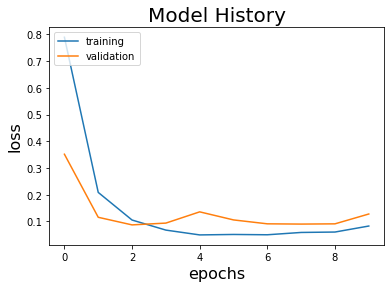

In [17]:
print(his2.history.keys())
plt.plot(his2.history['loss'])
plt.plot(his2.history['val_loss'])
plt.title("Model History", fontsize=20)
plt.xlabel("epochs", fontsize=16)
plt.ylabel("loss", fontsize=16)
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [18]:
y_prediction = model.predict(val_x)
y_prediction=np.argmax(y_prediction, axis=1)
validation_y=np.argmax(val_y, axis=1)
print("f1 score: ", f1_score(validation_y, y_prediction, average="macro"))
print("precision score: ", precision_score(validation_y, y_prediction, average="macro"))
print("recall score: ", recall_score(validation_y, y_prediction, average="macro"))    

f1 score:  0.9832758743342721
precision score:  0.9837391765718102
recall score:  0.9833333333333332


In [19]:
def decode_predicted_data(predicted_dat):
    mx = predicted_dat.max()
    idx = -1
    
    for i in range(9):
        if mx==predicted_dat[i]:
            idx = i
    
    return notes[idx]

Probability of classes:  [2.8123884e-04 9.9907768e-01 1.6789045e-05 5.2870605e-06 1.5087218e-04
 2.7448836e-05 1.3256812e-04 2.6272040e-05 2.2635479e-05 2.5928067e-04]

Note of 2 tk. 

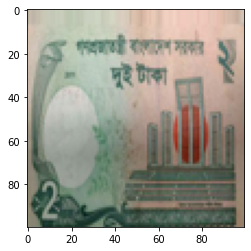

In [20]:
np_img = val_x[127]

plt.imshow(np_img)
org = np_img
data = org.reshape(1,IMG_SIZE,IMG_SIZE,3)
    
predicted_data = model.predict(data)[0]

print("Probability of classes: ", predicted_data)
    
ret = decode_predicted_data(predicted_data)
    
print("\nNote of", ret, "tk.", end=' ')

plt.show()